In [1]:
!pip install transformers #installing because we want to use pre_trained models, both from huggingface and our own models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pickle
import torch
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import get_linear_schedule_with_warmup
from torch.optim import Adam, NAdam
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning) #ignoring UserWarning from colab because I know what I am doing here
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/ESC324projectdrive/dav/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Simplify the code by creating a function to load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the pickle files using the function
neg_list_processed = load_pickle(base_dir + 'neg_list_processed.pickle')
het_list_processed = load_pickle(base_dir + 'het_list_processed.pickle')
homo_list_processed = load_pickle(base_dir + 'homo_list_processed.pickle')
rel_freq = load_pickle(base_dir + 'tag_dict.pickle')

In [6]:
print(rel_freq)

{'': 0.0003436426116838488, "''": 0.0003436426116838488, ',': 0.0003436426116838488, '-LRB-': 0.0003436426116838488, '-RRB-': 0.0003436426116838488, '.': 0.0003436426116838488, ':': 0.0003436426116838488, 'CC': 0.0003436426116838488, 'CD': 0.0010309278350515464, 'DT': 0.0003436426116838488, 'EX': 0.0003436426116838488, 'FW': 0.0006872852233676976, 'HYPH': 0.0003436426116838488, 'IN': 0.0024054982817869417, 'JJ': 0.11134020618556702, 'JJR': 0.0013745704467353953, 'JJS': 0.0013745704467353953, 'LS': 0.0003436426116838488, 'MD': 0.0013745704467353953, 'NFP': 0.0003436426116838488, 'NN': 0.3518900343642612, 'NNP': 0.07835051546391752, 'NNPS': 0.0013745704467353953, 'NNS': 0.09725085910652921, 'PDT': 0.0003436426116838488, 'POS': 0.0003436426116838488, 'PRP': 0.0006872852233676976, 'PRP$': 0.0003436426116838488, 'RB': 0.06632302405498282, 'RBR': 0.0006872852233676976, 'RBS': 0.0003436426116838488, 'RP': 0.001718213058419244, 'TO': 0.0003436426116838488, 'UH': 0.002061855670103093, 'VB': 0.0

In [7]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

mega_list = homo_list_processed + het_list_processed
#shuffling the list
random.shuffle(mega_list)

In [8]:
#mega_list is a giant list where each sublist of the following format:
#[['in/IN', 'the/DT', 'room/NN', 'the/DT', 'curtain/NNS', 'be/VBD', 'draw/VBN', ',/,', 'but/CC', 'the/DT', 'rest/NN', 'of/IN', 'the/DT', 'furniture/NN', 'be/VBD', 'real/JJ', './.'], ['In', 'the', 'room', 'the', 'curtains', 'were', 'drawn', ',', 'but', 'the', 'rest', 'of', 'the', 'furniture', 'was', 'real', '.'], ['draw/VBN']]. the first subsublist in the sublist is contains words in a sentence that have been POS tagged, second subsublist containts the original sentence, and third subsublist contains the pun word that has been POS tagged. Write code to tokenize this data, and fine tune a pretrained RoBERTa model to predict location of puns
load_dataset = False
if not load_dataset:
  input_sentences = [sublist[1] for sublist in mega_list]
  pos_sentences = [sublist[0] for sublist in mega_list]
  pun_words = [sublist[2][0] for sublist in mega_list]

  #calculating the max len for padding the inputs
  max_len = 0
  longest_joke = ""
  for sentence in input_sentences:
    if len(sentence) > max_len:
      max_len = len(sentence)
      longest_joke = " ".join(sentence) 
  max_len += 2
  print("Largest sentence in dataset has lenght = ", max_len)
  print("This joke is:\n", longest_joke)

  #creating an array of heuristic based on rel_freq mapping for each tag in dataset
  rel_freq_heuristic = []
  for sentence in pos_sentences:
    temp_heuristic = [0]
    for word in sentence:
      temp_heuristic.append(rel_freq.get(word.split("/")[1], 0))
    temp_heuristic += [0]*(max_len - len(temp_heuristic))
    rel_freq_heuristic.append(temp_heuristic)
  rel_freq_heuristic = torch.tensor(rel_freq_heuristic)

  input_ids = []
  attention_masks = []
  labels = []
  k_means_output = []
  acc_count = 0
  multiplier = 1

  for sentence, pun_word, pos_sentence in zip(input_sentences, pun_words, pos_sentences):
      encoded_data = tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length = max_len, #we are padding all sentences to a max_len elements (words + punction)
          pad_to_max_length = True,
          return_attention_mask = False,
          return_tensors='pt'
      )

      temp = np.array(encoded_data['input_ids'][0].tolist().copy())
      
      temp = temp[temp != temp[-1]] #remove padding
      num_clusters = max(math.ceil(len(temp)*multiplier), min(4, len(sentence)))

      kmeans = KMeans(n_clusters = num_clusters, n_init = 10)
      kmeans.fit(temp.reshape(-1, 1))
      att_labels = np.array(kmeans.labels_)
      k_means_output.append(kmeans.labels_)

      unique, count = (np.unique(att_labels, return_counts = True))

      idx = np.argsort(count)
      count = count[idx]
      unique = unique[idx]

      first_mode = unique[-1]
      attention_mask = torch.tensor([0] * max_len)
      indices = np.where(att_labels == first_mode)
      attention_mask[indices] = 1

      
      lone_word = unique[np.where(count == 1)]
      lone_word_ind = np.where(np.isin(att_labels, lone_word))[0]
      attention_mask[lone_word_ind] = 1

      if len(unique) > 1:
        second_lowest_chosen = unique[1]
        indices2 = np.where(att_labels == second_lowest_chosen)
        attention_mask[indices2] = 1      

      if attention_mask[pos_sentence.index(pun_word) + 1] == 0:
        acc_count += 1
                                                  
      input_ids.append(encoded_data['input_ids'][0])
      attention_masks.append(torch.tensor(attention_mask))
      labels.append(pos_sentence.index(pun_word) + 1)
  print("Max accuracy = ", 1 - acc_count/len(pos_sentences))

  #checking if the label index is within the range of max_len, else set it to the first word in the sentence
  labels = [label if label < max_len else 0 for label in labels]
  input_ids = torch.stack(input_ids, dim = 0)
  attention_masks = torch.stack(attention_masks, dim = 0)
  labels = torch.tensor(labels)

  #splitting the data into train, validation and test sets
  train_inputs, val_test_inputs, train_labels, val_test_labels, train_masks, val_test_masks, train_freq_heuristic, val_test_freq_heuristic = train_test_split(input_ids, labels, attention_masks, rel_freq_heuristic, random_state = seed, test_size = 0.3)
  val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks, val_freq_heuristic, test_freq_heuristic = train_test_split(val_test_inputs, val_test_labels, val_test_masks, val_test_freq_heuristic, random_state = seed, test_size = 0.5)

  #creating DataLoader
  batch_size = 4

  train_data = TensorDataset(train_inputs, train_masks, train_labels, train_freq_heuristic)
  train_dataloader = DataLoader(train_data, batch_size=batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels, val_freq_heuristic)
  val_dataloader = DataLoader(val_data, batch_size=batch_size)

  test_data = TensorDataset(test_inputs, test_masks, test_labels, test_freq_heuristic)
  test_dataloader = DataLoader(test_data, batch_size=batch_size)

  print(len(train_dataloader))
  print(len(val_dataloader))
  print(len(test_dataloader))

  #writing the dataloaders to a pickle file so that we can use them later while using ensembles
  with open(base_dir + 'dataloaders_deberta_old1.pickle', 'wb') as f:
      f.truncate(0)
      pickle.dump((train_dataloader, val_dataloader, test_dataloader), f)
  #close file
  f.close()
else:
  #load the dataloaders
  (train_dataloader, val_dataloader, test_dataloader) = load_pickle(base_dir + 'dataloaders_deberta_old1.pickle')
  max_len = 79
  print("Loaded presaved dataloader")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Largest sentence in dataset has lenght =  79
This joke is:
 The celebration of the royal wedding progressed well into the night . As he stumbled outside to await his ride home one inebriated nobleman , attracted by the bright lights , made his way to the theater district and sat down below one of the brightly illuminated theater signs to await his car . The driver , unfamiliar with both the nobleman and the area , was instructed to look for a well - lit marquis .
Max accuracy =  0.9706601466992665
501
108
108


In [12]:
#function to calculate accuracy of the model for a given batch of data
def accuracy(model_output, ground_truth_labels, rel_freq_heuristic):
  model_output = torch.softmax(model_output.detach().cpu(), dim = 1) * rel_freq_heuristic.cpu()
  model_output = torch.argmax(model_output, dim=1)
  model_output = np.array(model_output)
  ground_truth_labels = np.array(ground_truth_labels.detach().cpu())

  #checking how many values in model_output are equal to their corresponding values in ground_truth_labels
  num_correct = np.sum(model_output == ground_truth_labels)
  accuracy_val = num_correct / len(ground_truth_labels)
  return accuracy_val

In [13]:
# Fine-tune the DeBERTa model
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels = max_len)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(["Using CPU", "Using Cuda"][int(torch.cuda.is_available())])
model.to(device)

optimizer = NAdam(model.parameters(), lr = 0.000019) #75.92% 0.000019 epoch 10 mult 1 batch_size 4 seed 42 tes_acc 74.0 if let run fully
epochs = 200
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.d

Using Cuda


In [14]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

save = 1 #set to 1 to save model after every 10 epochs of training
sliding_window_width = 15 #set to the width of sliding window to check of overfitting
epochs_trained = 0 #number of epochs the model has actually been trained for

#training loop
epochs_pre_trained = 0
for epoch in tqdm(range(epochs_pre_trained, epochs_pre_trained + epochs), desc = "Training", colour = "green"):
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        #forward pass
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        #calculating accuracy for batch
        total_train_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

        #backward pass
        loss.backward()

        #updating parameters
        optimizer.step()
        scheduler.step()
        model.zero_grad()

        # Delete unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    #calculating training accuracy
    avg_train_acc = total_train_acc / len(train_dataloader)
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_acc)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    for batch in val_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        #Congrats! You have finally made it to here. You found our secret Easter egg!
        #Here is a pun for you: Two peanuts walk into a bar, and one was a-salted
        #Anyway, let's get back to business and continue on our journey to pun-derful enlightenment.

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()
            #calculating accuracy for batch
            total_val_acc += accuracy(outputs[1], labels, rel_freq_heuristic)
            
        #deleting unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    #calculating average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_acc = total_val_acc / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_acc.append(avg_val_acc)   

    print(f"\nEpoch {epoch}\n\tTraining Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}\n\tTraining Accuracy: {avg_train_acc}, Validation Accuracy: {avg_val_acc}")

    if (epoch + 1) % 10 == 0 and save:
        model.save_pretrained(base_dir + 'deberta_model_' + str(epoch + 1) + '_epochs')
    
    epochs_trained = epoch + 1
    #early stopping
    if epoch > sliding_window_width:
        window = val_loss[epoch - sliding_window_width: epoch]
        if all(val_loss[epoch] > x for x in window):
            print(f"\nEarly stopping at epoch {epoch} due to overfitting")
            model.save_pretrained(base_dir + 'deberta_model_' + str(epoch + 1) + '_epochs')
            break

Training:   0%|          | 1/200 [01:19<4:22:32, 79.16s/it]


Epoch 0
	Training Loss: 2.8093751466678762, Validation Loss: 2.101398519895695
	Training Accuracy: 0.3652694610778443, Validation Accuracy: 0.4675925925925926


Training:   1%|          | 2/200 [02:36<4:17:20, 77.98s/it]


Epoch 1
	Training Loss: 1.9172006069781062, Validation Loss: 1.7656037630858246
	Training Accuracy: 0.5434131736526946, Validation Accuracy: 0.5995370370370371


Training:   2%|▏         | 3/200 [03:53<4:14:19, 77.46s/it]


Epoch 2
	Training Loss: 1.6594491465957817, Validation Loss: 1.6770157620862678
	Training Accuracy: 0.6127744510978044, Validation Accuracy: 0.6018518518518519


Training:   2%|▏         | 4/200 [05:10<4:12:51, 77.40s/it]


Epoch 3
	Training Loss: 1.3886248349786519, Validation Loss: 1.5484989944983412
	Training Accuracy: 0.6866267465069861, Validation Accuracy: 0.6666666666666666


Training:   2%|▎         | 5/200 [06:29<4:13:09, 77.89s/it]


Epoch 4
	Training Loss: 1.2153105160552347, Validation Loss: 1.4835677530478548
	Training Accuracy: 0.7210578842315369, Validation Accuracy: 0.7129629629629629


Training:   3%|▎         | 6/200 [07:47<4:12:03, 77.96s/it]


Epoch 5
	Training Loss: 1.0654084721130288, Validation Loss: 1.4694120718373194
	Training Accuracy: 0.7634730538922155, Validation Accuracy: 0.6898148148148148


Training:   4%|▎         | 7/200 [09:04<4:09:40, 77.62s/it]


Epoch 6
	Training Loss: 0.8949388047148605, Validation Loss: 1.5644671192944601
	Training Accuracy: 0.81187624750499, Validation Accuracy: 0.6967592592592593


Training:   4%|▍         | 8/200 [10:21<4:08:01, 77.51s/it]


Epoch 7
	Training Loss: 0.8030608894002295, Validation Loss: 1.3780212167271033
	Training Accuracy: 0.8338323353293413, Validation Accuracy: 0.7291666666666666


Training:   4%|▍         | 9/200 [11:38<4:05:56, 77.26s/it]


Epoch 8
	Training Loss: 0.691863279566615, Validation Loss: 1.4692966496847846
	Training Accuracy: 0.8488023952095808, Validation Accuracy: 0.7083333333333334


Training:   5%|▌         | 10/200 [12:56<4:05:50, 77.63s/it]


Epoch 9
	Training Loss: 0.6007957286359427, Validation Loss: 1.477950080987756
	Training Accuracy: 0.8727544910179641, Validation Accuracy: 0.7384259259259259


Training:   6%|▌         | 11/200 [14:45<4:35:00, 87.30s/it]


Epoch 10
	Training Loss: 0.503016020818251, Validation Loss: 1.4738287721432883
	Training Accuracy: 0.9006986027944112, Validation Accuracy: 0.7592592592592593


Training:   6%|▌         | 12/200 [16:03<4:23:57, 84.24s/it]


Epoch 11
	Training Loss: 0.47376507660652883, Validation Loss: 1.6518534395145252
	Training Accuracy: 0.9026946107784432, Validation Accuracy: 0.7291666666666666


Training:   6%|▋         | 13/200 [17:21<4:16:40, 82.35s/it]


Epoch 12
	Training Loss: 0.4242962594655251, Validation Loss: 1.5101006288098655
	Training Accuracy: 0.9106786427145709, Validation Accuracy: 0.75


Training:   7%|▋         | 14/200 [18:39<4:11:58, 81.28s/it]


Epoch 13
	Training Loss: 0.36077476950072335, Validation Loss: 1.638353115652636
	Training Accuracy: 0.9321357285429142, Validation Accuracy: 0.75


Training:   8%|▊         | 15/200 [19:57<4:06:46, 80.04s/it]


Epoch 14
	Training Loss: 0.30459669605362233, Validation Loss: 1.5687533030803833
	Training Accuracy: 0.9366267465069861, Validation Accuracy: 0.7384259259259259


Training:   8%|▊         | 16/200 [21:13<4:02:22, 79.03s/it]


Epoch 15
	Training Loss: 0.30293476080453163, Validation Loss: 1.6667009267559345
	Training Accuracy: 0.9346307385229541, Validation Accuracy: 0.7314814814814815


Training:   8%|▊         | 17/200 [22:30<3:58:44, 78.27s/it]


Epoch 16
	Training Loss: 0.27933530964537295, Validation Loss: 1.7059036027424521
	Training Accuracy: 0.9461077844311377, Validation Accuracy: 0.7384259259259259


Training:   9%|▉         | 18/200 [23:47<3:56:35, 78.00s/it]


Epoch 17
	Training Loss: 0.25955092992555506, Validation Loss: 1.687980254562313
	Training Accuracy: 0.9491017964071856, Validation Accuracy: 0.7384259259259259

Epoch 18
	Training Loss: 0.2029294228541875, Validation Loss: 1.7996772253364153
	Training Accuracy: 0.9610778443113772, Validation Accuracy: 0.7453703703703703

Early stopping at epoch 18 due to overfitting


Training:   9%|▉         | 18/200 [25:05<4:13:44, 83.65s/it]


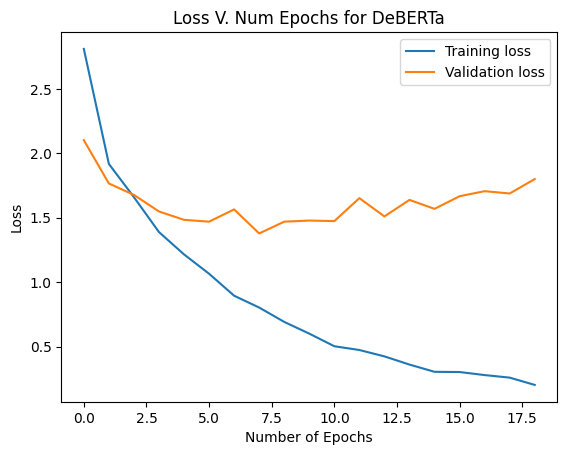

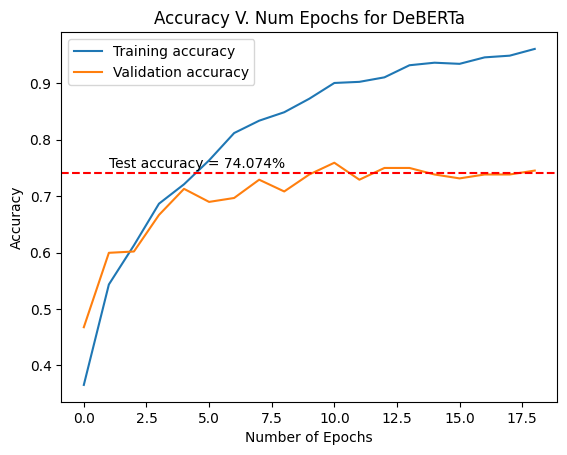

In [19]:
#plotting the training and validation loss
plt.plot(list(range(epochs_trained)), train_loss, label = 'Training loss')
plt.plot(list(range(epochs_trained)), val_loss, label = 'Validation loss')
plt.title("Loss V. Num Epochs for DeBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#plotting the training and validation accuracy
plt.plot(list(range(epochs_trained)), train_acc, label = 'Training accuracy')
plt.plot(list(range(epochs_trained)), val_acc, label = 'Validation accuracy')
plt.axhline(y = 0.7407407407407407, color = 'r', linestyle = '--')
plt.annotate('Test accuracy = 74.074%', xy = (1, 0.7407407407407407), xytext = (1, 0.75))
plt.title("Accuracy V. Num Epochs for DeBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
#testing loop
model.eval()
total_test_loss = 0
total_test_acc = 0
for batch in test_dataloader:
    input_ids, attention_mask, labels, rel_freq_heuristic = batch
    input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_test_loss += loss.item()
        total_test_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

    #deleting unnecessary values to save memory
    del input_ids, attention_mask, labels, outputs, loss

#calculating average test loss
avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_acc = total_test_acc / len(test_dataloader)
print(f"Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {avg_test_acc}")

Test Loss: 1.6675734759019516
Test Accuracy: 0.7407407407407407


In [17]:
print(train_loss)
print(val_loss)
print(train_acc)
print(val_acc)

# Save the training and validation loss and accuracy to a pickle file
with open(base_dir + 'loss_acc_deberta.pickle', 'wb') as f:
    f.truncate(0)
    pickle.dump((train_loss, val_loss, train_acc, val_acc), f)
#close file
f.close()

[2.8093751466678762, 1.9172006069781062, 1.6594491465957817, 1.3886248349786519, 1.2153105160552347, 1.0654084721130288, 0.8949388047148605, 0.8030608894002295, 0.691863279566615, 0.6007957286359427, 0.503016020818251, 0.47376507660652883, 0.4242962594655251, 0.36077476950072335, 0.30459669605362233, 0.30293476080453163, 0.27933530964537295, 0.25955092992555506, 0.2029294228541875]
[2.101398519895695, 1.7656037630858246, 1.6770157620862678, 1.5484989944983412, 1.4835677530478548, 1.4694120718373194, 1.5644671192944601, 1.3780212167271033, 1.4692966496847846, 1.477950080987756, 1.4738287721432883, 1.6518534395145252, 1.5101006288098655, 1.638353115652636, 1.5687533030803833, 1.6667009267559345, 1.7059036027424521, 1.687980254562313, 1.7996772253364153]
[0.3652694610778443, 0.5434131736526946, 0.6127744510978044, 0.6866267465069861, 0.7210578842315369, 0.7634730538922155, 0.81187624750499, 0.8338323353293413, 0.8488023952095808, 0.8727544910179641, 0.9006986027944112, 0.9026946107784432,